# Distortion Examples

WebbPSF has added a new feature which allows users to add detector effects and distortion to their PSFs. This feature adds 2 new extensions to the PSF HDUlist object output. Instead of having 2 extensions: the 0th being the over-sampled PSF and the 1st being the detector-sampled PSF, turning on the distortion feature will output a PSF with 4 extensions: the 0th and 1st stay the same, the 2nd is the distorted over-sampled PSF and the 3rd is the distorted detector-sampled PSF.

The necessary keywords arguments to turn on this distortion feature are locatesd in the calc_psf function and are automatically turned on.

This notebook will walk through this feature.

First we import the necessary packages

In [1]:
import matplotlib.pyplot as plt
%pylab inline

import webbpsf

Populating the interactive namespace from numpy and matplotlib


## Quick summary of the distortion effects applied

* NIRCam, NIRISS, and FGS PSFs have a distortion based on the detector shape and a rotation from how the detector is rotated applied


* MIRI PSFs have the distortion based on the detector shape and a scattering effect from the MIRI detector applied
    * Note that MIRI LRS mode is not currently supported


* NIRSpec PSFs have just the distortion based on the detector shape applied

Further descriptions of these effects can be found below under the heading "Distortion types applied to different instruments"

## Creating a PSF with distortion

The distortion application feature is turned on using the calc_psf keyword argument add_distortion=True (and this keyword is set to True by default). Users can also determine the size of their distorted PSF arrays using the calc_psf keyword crop_psf=True/False, which will be described in more detail later.

In [2]:
# Create a PSF with distortion
nir = webbpsf.NIRCam()
nir.filter = "F070W"
psf = nir.calc_psf()  # the keywords add_distortion and crop_psf are automatically set to True

# Note the 4 extensions, where ext=2 is the distorted version of ext=0 and ext=3 is the distorted version of ext=1
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      91   (644, 644)   float64   
  1  DET_SAMP      1 ImageHDU        93   (161, 161)   float64   
  2  OVERDIST      1 ImageHDU       136   (644, 644)   float64   
  3  DET_DIST      1 ImageHDU       138   (161, 161)   float64   


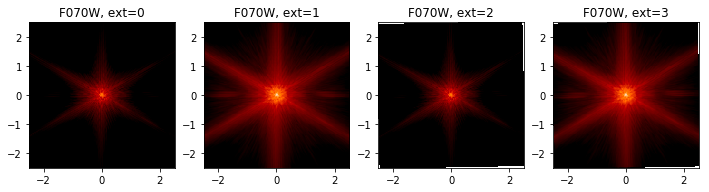

In [3]:
# Plot the 4 extensions of the PSF HDUlist object
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(12,15))

for i, axval in enumerate([ax1, ax2, ax3, ax4]):
    webbpsf.display_psf(psf, ext=i, ax=axval, colorbar=False, title="F070W, ext={}".format(i))
    
# Note that the white edges on the distorted PSFs are 0s (displayed as white due to the 
# log plotting) and are not NaNs

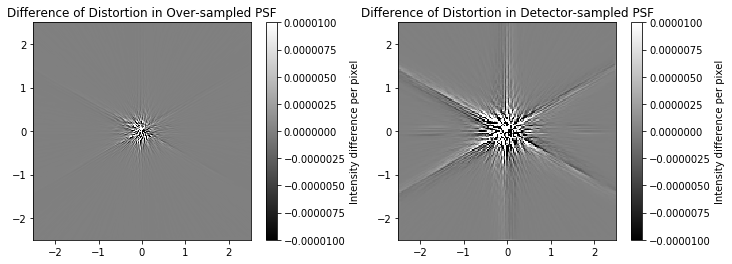

In [4]:
# Display the difference between the distorted and un-distorted PSFs
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

webbpsf.display_psf_difference(psf, psf, ext1=0, ext2=2, ax=ax1, 
                               title="Difference of Distortion in Over-sampled PSF",
                               vmin=-1e-5, vmax=1e-5)
webbpsf.display_psf_difference(psf, psf, ext1=1, ext2=3, ax=ax2, 
                               title="Difference of Distortion in Detector-sampled PSF",
                               vmin=-1e-5, vmax=1e-5)

## Setting crop_psf to True/False

For the NIRCam, NIRISS, and FGS PSFs, part of this distortion feature involves rotating the PSFs to match their detector's rotation on the telescope's focal plane. Due to this rotation, the distorted PSF data array is larger than the un-distorted PSF array.

The header keyword "crop_psf" inside the calc_psf function gives users some license over this application.

Users have the option to set crop_psf=True to crop the PSF back down to the size of the un-distorted array in order to facilitate easy comparison between the distorted and un-distorted PSF extensions. Or users can set crop_psf=False to leave the PSF un-cropped in order to retain as much of the data as possible.

MIRI and NIRSpec's rotation is implemented elsewhere in the WebbPSF code, so this keyword argument is not applicable to these instruments.

In [5]:
niriss = webbpsf.NIRISS()
psf = niriss.calc_psf(crop_psf=True)  #crop_psf is set to True by default

# With crop_psf=True, the distorted and un-distorted PSF array sizes will match

print("The un-distorted over-sampled PSF has an array size of {} x {}".format(psf[0].data.shape[1], 
                                                                              psf[0].data.shape[0]))
print("The distorted over-sampled PSF has an array size of {} x {}".format(psf[2].data.shape[1], 
                                                                           psf[2].data.shape[0]))

The un-distorted over-sampled PSF has an array size of 304 x 304
The distorted over-sampled PSF has an array size of 304 x 304


In [6]:
niriss = webbpsf.NIRISS()
psf = niriss.calc_psf(crop_psf=False)  #crop_psf is set to True by default

# With crop_psf=False, the distorted PSF array will be larger than the un-distorted PSF array

print("The un-distorted over-sampled PSF has an array size of {} x {}".format(psf[0].data.shape[1], 
                                                                              psf[0].data.shape[0]))
print("The distorted over-sampled PSF has an array size of {} x {}".format(psf[2].data.shape[1], 
                                                                           psf[2].data.shape[0]))

The un-distorted over-sampled PSF has an array size of 304 x 304
The distorted over-sampled PSF has an array size of 307 x 307


## Turning distortion off

If you want to turn the distortion function off, set the calc_psf keyword add_distortion=False. By default it is set to True. You do not also need to set the crop_psf keyword argument.

In [7]:
mir = webbpsf.MIRI()
psf = mir.calc_psf(add_distortion=False)

# Note that there are only 2 extensions now, both of which are un-distorted
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      71   (432, 432)   float64   
  1  DET_SAMP      1 ImageHDU        73   (108, 108)   float64   


## Distortion effects applied to different instruments

Different JWST instruments require different distortions to be applied to them:

1) All of the instruments has a 4 (or 5 depending on the instrument) degree polynomial applied to the PSF which models the distortion of the detector. This distortion takes into account any skew of the detector axes and any varying in pixelscale in x and y across the detector.
* The distorted PSF extensions will include the header keyword DISTORT=True (to show that the distortion was applied), SIAF_VER set to the version number of the SIAF file which contains the polynomial coefficients that are applied to the PSF, and COEF_XXX each of which gives a polynomial coefficient.

2) NIRCam, NIRISS, and FGS have a rotation applied to them to include the small rotation of their detectors on the focal plane.
* The distorted PSF extensions will include the header keyword ROTATION which is set to the rotation applied to the PSF in degrees.
* Note that MIRI and NIRSpec PSFs also have this rotation applied, but it was applied to the PSFs previously and thus this rotation will be present in both their distorted and un-distorted PSFs.
    
3) MIRI has a scattering effect which creates an exponentially decaying cross shape centered on the PSF.
* The distorted PSF extensions will include the header keyword MIR_DIST=True (to show that the MIRI scattering effect was applied), and KERN_AMP and KERNFOLD set to the amplitude and e folding length used in the creation of the exponential function that created the cross shape (A and B in A*exp(-x/B)).
* Note that this distortion was added by applying this exponential kernel to the over-sampled PSF and then binning down the PSF to detector sampling. So these kernel values only apply directly to the over-sampled PSF.

### NIRCam, NIRISS, and FGS Example: Has the distortion polynomial and rotation applied

<Figure size 432x288 with 0 Axes>

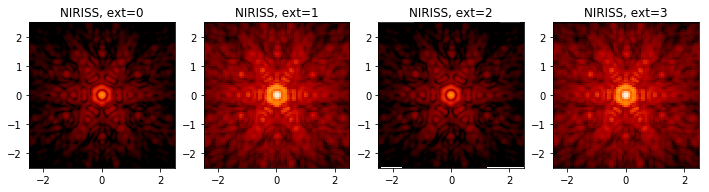

<Figure size 432x288 with 0 Axes>

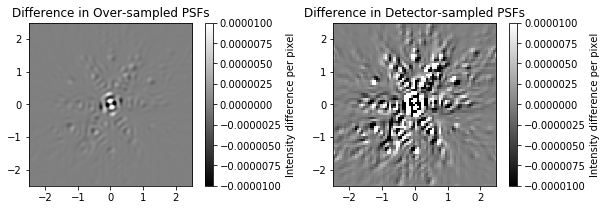

In [20]:
niriss = webbpsf.NIRISS()
niriss.filter = "F480M"
psf = niriss.calc_psf()

# Plot the extensions
plt.figure()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(12,15))
for i, axval in enumerate([ax1, ax2, ax3, ax4]):
    webbpsf.display_psf(psf, ext=i, ax=axval, colorbar=False, title="NIRISS, ext={}".format(i))
    
# Plot the differences
plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))
webbpsf.display_psf_difference(psf, psf, ext1=0, ext2=2, ax=ax1, title="Difference in Over-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)
webbpsf.display_psf_difference(psf, psf, ext1=1, ext2=3, ax=ax2, title="Difference in Detector-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)

In [21]:
# Note the added header keywords:
print("Since the distortion has been applied, DISTORT = {}".format(psf[2].header["DISTORT"]))
print("The SIAF version that set these polynomial coefficeints is SIAF_VER = {}".format(psf[2].header["SIAF_VER"]))
print("One example of the coefficent list is: COEF_X10 = {}".format(psf[2].header["COEF_X10"]))

print("The rotation value is set under ROTATION = {}".format(psf[2].header["ROTATION"]))

Since the distortion has been applied, DISTORT = True
The SIAF version that set these polynomial coefficeints is SIAF_VER = PRDOPSSOC-H-015
One example of the coefficent list is: COEF_X10 = 15.2922283718632
The rotation value is set under ROTATION = 0.56987


### MIRI Example: Has the distortion polynomial and MIRI's scattering effect applied

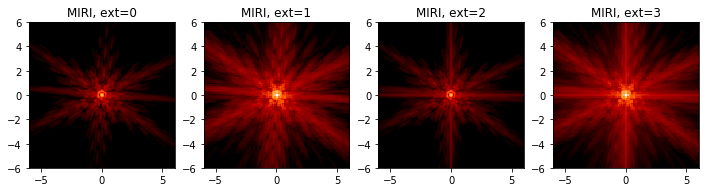

<Figure size 432x288 with 0 Axes>

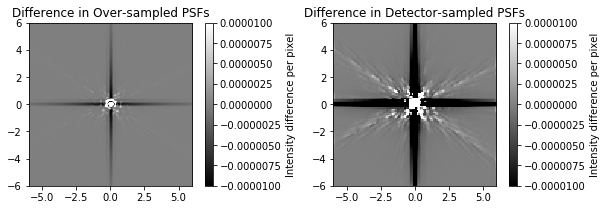

In [10]:
mir = webbpsf.MIRI()
mir.filter = "F560W"
psf = mir.calc_psf()

# Plot the extensions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(12,15))
for i, axval in enumerate([ax1, ax2, ax3, ax4]):
    webbpsf.display_psf(psf, ext=i, ax=axval, colorbar=False, title="MIRI, ext={}".format(i))

# Plot the differences
plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))
webbpsf.display_psf_difference(psf, psf, ext1=0, ext2=2, ax=ax1, title="Difference in Over-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)
webbpsf.display_psf_difference(psf, psf, ext1=1, ext2=3, ax=ax2, title="Difference in Detector-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)

In [11]:
# Note the addeed header keywords:
print("Since distortion has been applied, DISTORT = {}".format(psf[2].header["DISTORT"]))
print("The SIAF version that set these polynomial coefficeints is SIAF_VER = {}".format(psf[2].header["SIAF_VER"]))
print("One example of the coefficent list is: COEF_X10 = {}".format(psf[2].header["COEF_X10"]))

print("Since the scattering effect has been applied, MIR_DIST = {}".format(psf[2].header["MIR_DIST"]))
print("The amplitude used to create the cross shape is KERN_AMP = {}".format(psf[2].header["KERN_AMP"]))
print("The e-folding length used to create the cross shape is KERNFOLD = {}".format(psf[2].header["KERNFOLD"]))

Since distortion has been applied, DISTORT = True
The SIAF version that set these polynomial coefficeints is SIAF_VER = PRDOPSSOC-H-015
One example of the coefficent list is: COEF_X10 = 8.97621813017046
Since the scattering effect has been applied, MIR_DIST = True
The amplitude used to create the cross shape is KERN_AMP = 0.0022
The e-folding length used to create the cross shape is KERNFOLD = 25


### NIRSpec Example: Has just the distortion polynomial applied

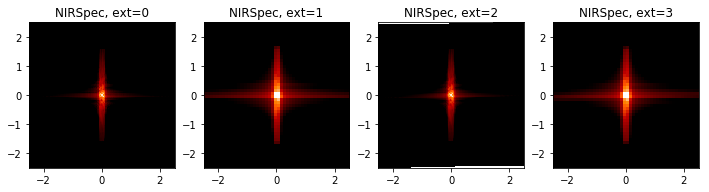

<Figure size 432x288 with 0 Axes>

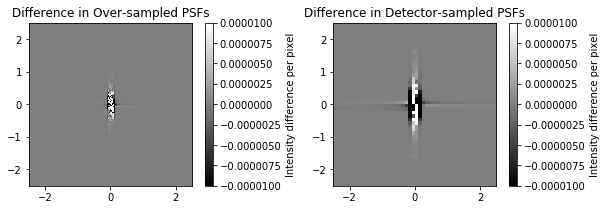

In [12]:
nirspec = webbpsf.NIRSpec()
nirspec.image_mask = "S200A1"
psf = nirspec.calc_psf()

# Plot the extensions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(12,15))
for i, axval in enumerate([ax1, ax2, ax3, ax4]):
    webbpsf.display_psf(psf, ext=i, ax=axval, colorbar=False, title="NIRSpec, ext={}".format(i))
    
# Plot the differences
plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))
webbpsf.display_psf_difference(psf, psf, ext1=0, ext2=2, ax=ax1, title="Difference in Over-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)
webbpsf.display_psf_difference(psf, psf, ext1=1, ext2=3, ax=ax2, title="Difference in Detector-sampled PSFs",
                               vmin=-1e-5, vmax=1e-5)

In [13]:
# Note the addeed header keywords:
print("Since distortion has been applied, DISTORT = {}".format(psf[2].header["DISTORT"]))
print("The SIAF version that set these polynomial coefficeints is SIAF_VER = {}".format(psf[2].header["SIAF_VER"]))
print("One example of the coefficent list is: COEF_X10 = {}".format(psf[2].header["COEF_X10"]))

Since distortion has been applied, DISTORT = True
The SIAF version that set these polynomial coefficeints is SIAF_VER = PRDOPSSOC-H-015
One example of the coefficent list is: COEF_X10 = 16358.1839909
